In [10]:
%matplotlib inline

"""
Example of creating a radar chart (a.k.a. a spider or star chart) [1]_.

Although this example allows a frame of either 'circle' or 'polygon', polygon
frames don't have proper gridlines (the lines are circles instead of polygons).
It's possible to get a polygon grid by setting GRIDLINE_INTERPOLATION_STEPS in
matplotlib.axis to the desired number of vertices, but the orientation of the
polygon is not aligned with the radial axes.

.. [1] http://en.wikipedia.org/wiki/Radar_chart
"""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels, frac=1.3)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

In [41]:
muscles = {'back':.5, 'chest':.7,'abs':.2}

def generate_spider(muscles):
    """ Generates a spider chart showing user's muscle_groups """

    values = muscles.values()
    values = [int(100*val/sum(values)) for val in values]
    labels = muscles.keys()

    #=====[ set font, linestyle, and fit parameters for chart ]=====
    font_size = 6
    label_font_size = 8
    matplotlib.rcParams.update({'font.size': font_size})
    matplotlib.rcParams.update({'figure.autolayout': True})
    plt.rc('grid', color='k', linewidth=1, linestyle=':',alpha=0.25)

    #=====[ Instantiate polar plot ]=====
    N = len(labels)
    theta = radar_factory(N, frame='circle')

    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(1,1,1,projection='radar')

    #=====[ Plot values, ideal values, and set labels ]=====
    ax.plot(theta, values, color='b')
    ax.fill(theta, values, color='b',alpha = 0.25)
    ax.set_varlabels(labels)
    ax.set_yticklabels([])

    #=====[ Get x,y locations for setting labels on spider chat ]=====
    radians = np.arange(np.pi/2,np.pi*9/4,np.pi*2/len(values))
#     adjustments = [15 if val < 90 else -15 for val in values]

    #=====[ Added percentage labels to each macro nutrient ]=====
    for idx, val in enumerate(values):
        ax.text(radians[idx],val + 5, str(val) + '%', fontsize=label_font_size,ha='center',va='center',color='k')

    fig.savefig('spider.png',dpi=300)

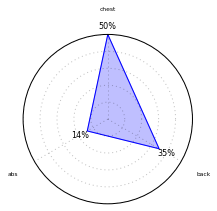

In [42]:
generate_spider(muscles)